In [1]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import sklearn
import math

# Aux functions

In [2]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return np.argmax(v,axis=1)
def sigmoid(v,derivate=False):
    if derivate:
        return v*(1-v)
    else:
        return 1/(1+np.exp(-v))
def relu(v,derivate=False):
    if derivate:
        return (v>0)
    else:
        return v*(v>0)
def tanh(v,derivate=False):
    if derivate:
        return 1-v*v
    else:
        return np.tanh(v)
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def cross_entropy_cost(Y,P):
    return -(Y*np.log(P)).mean()
def accuracy(Y,P):
    return (Y==P).mean()
def rmse(Y,P):
    return np.sqrt(((P-Y)**2).mean())

# La classe

In [70]:
class NN_01(object):
    def __init__(self,
                 net_structure,
                 f_encode_Y=one_hot_encoder,
                 f_decode_Y=one_hot_decoder,
                 f_transfer=sigmoid,
                 f_output=lambda v: softmax(sigmoid(v)),
                 f_cost=cross_entropy_cost,
                 f_accuracy=accuracy):
        self.net_structure=net_structure
        self.f_encode_Y=f_encode_Y
        self.f_decode_Y=f_decode_Y
        self.f_transfer=f_transfer
        self.f_output=f_output
        self.f_cost=f_cost
        self.f_accuracy=f_accuracy
    def train(self,X,Y,W_0=None,
              frac_test=0.2,random_state=None,
              learning_rate=10e-7,regularization=0,num_rounds=100001,
              report_step=100,print_every=5000,print_acc=True,plot_cost=True):
        self.training_report=[]
        X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
        num_test=int(frac_test*X.shape[0])
        X_train,Y_train=X[:-num_test],Y[:-num_test]
        X_test,Y_test=X[-num_test:],Y[-num_test:]
        eY_train,eY_test=self.f_encode_Y(Y_train),self.f_encode_Y(Y_test)
        if W_0!=None:
            self.W=W_0
        else:
            self.W=self.populate_W(X_train,eY_train)
        peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
        global_start=datetime.datetime.now()
        reporting_start=datetime.datetime.now()
        for n in range(num_rounds):
            delta=peY_train[-1]-eY_train
            for l in reversed(range(len(self.W))):
                gradient,new_delta=self.derivate_layer(self.W[l],peY_train[l],delta)
                delta=new_delta
                self.W[l]=self.W[l]*(1-learning_rate*regularization)-learning_rate*gradient
            peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
            if n % report_step==0:
                c_train,c_test=self.f_cost(eY_train,peY_train[-1]),self.f_cost(eY_test,peY_test[-1])
                pY_train,pY_test=self.f_decode_Y(peY_train[-1]),self.f_decode_Y(peY_test[-1])
                acc_train,acc_test=self.f_accuracy(Y_train,pY_train),self.f_accuracy(Y_test,pY_test)
                global_duration=(datetime.datetime.now()-global_start).total_seconds()
                if print_every and n % print_every==0:
                    global_left=global_duration*(num_rounds-n+1)/(n+1)
                    reporting_duration=(datetime.datetime.now()-reporting_start).total_seconds()
                    reporting_start=datetime.datetime.now()
                    print('{:5d} '.format(n)),
                    print('{:0.5f} {:0.5f} '.format(acc_train,acc_test)),
                    print('{:0.5f} {:0.5f} '.format(c_train,c_test)),
                    print('{:7.2f} {:7.2f}  {:7.2f}'.format(reporting_duration,global_duration,global_left))
                self.training_report.append([n,acc_train,acc_test,c_train,c_test,global_duration])
        if plot_cost:
            plt.plot([r[3] for r in self.training_report])
            plt.plot([r[4] for r in self.training_report])
            plt.show()
    def populate_W(self,X,T):
        net_structure=[X[0].size]+self.net_structure+[T[0].size]
        W=[]
        for i in range(len(net_structure)-1):
            nodes_this=net_structure[i]+1
            nodes_next=net_structure[i+1]
            W.append(np.random.randn(nodes_this,nodes_next)/np.sqrt(nodes_this+nodes_next))
        return W
    def derivate_layer(self,W_layer,layer,delta):
        next_delta=delta.dot(W_layer[:-1,:].T)*self.f_transfer(layer,derivate=True)
        layer=np.append(layer,np.ones((layer.shape[0],1)),1)
        return layer.T.dot(delta),next_delta
    def predict(self,X):
        return self.f_decode_Y(self.feed_forward(X))
    def feed_forward(self,X):
        v=[X]
        for l in range(len(self.W)-1):
            v.append(self.f_transfer(self.process_layer(v[-1],self.W[l])))
        v.append(self.f_output(self.process_layer(v[-1],self.W[-1])))
        return v
    def process_layer(self,X,W):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        return X.dot(W)

# 2D, multiclass data

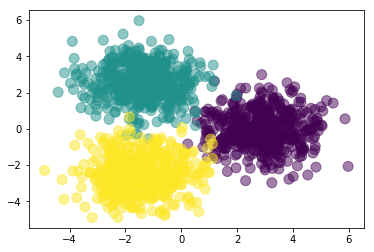

In [81]:
num_classes=3
num_per_class=500
r=3*num_classes/math.pi
d=2*math.pi/num_classes
centers=[[r*math.cos(n*d),r*math.sin(n*d)] for n in range(num_classes)]
X_lst=[]
for c in range(num_classes):
    X_lst.append(np.random.randn(num_per_class,2) + np.array(centers[c]))
X_class=np.concatenate(X_lst,axis=0)
Y_class=np.array([ co for l in [[cl]*num_per_class for cl in range(num_classes)] for co in l ])
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

In [82]:
my_NN=NN_01(net_structure=[3],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.32833 0.35333  0.38046 0.37817     0.00    0.00    12.51
 1000  0.90000 0.91667  0.28232 0.28052     0.70    0.70     6.33
 2000  0.97417 0.98000  0.24223 0.24085     0.68    1.39     5.55
 3000  0.98083 0.98000  0.22512 0.22394     0.69    2.08     4.85
 4000  0.98417 0.98000  0.21659 0.21554     0.69    2.77     4.15
 5000  0.98417 0.98000  0.21206 0.21109     0.69    3.46     3.46
 6000  0.98417 0.98000  0.20955 0.20863     0.69    4.15     2.76
 7000  0.98417 0.98000  0.20811 0.20721     0.69    4.84     2.07
 8000  0.98417 0.98000  0.20725 0.20636     0.69    5.53     1.38
 9000  0.98417 0.98000  0.20674 0.20583     0.68    6.21     0.69
10000  0.98417 0.98000  0.20642 0.20547     0.68    6.89     0.00


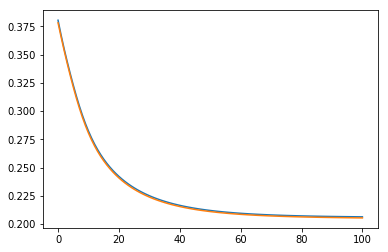

CPU times: user 7.04 s, sys: 168 ms, total: 7.21 s
Wall time: 7.04 s


In [83]:
%%time
my_NN.train(X_class,Y_class,learning_rate=10e-6,regularization=0,num_rounds=10001,print_every=1000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# 2D, single class data

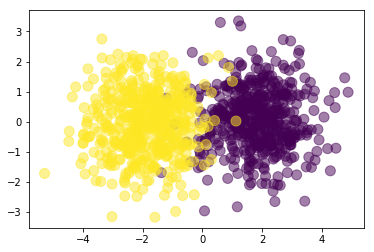

In [84]:
num_classes=2
num_per_class=500
r=3*num_classes/math.pi
d=2*math.pi/num_classes
centers=[[r*math.cos(n*d),r*math.sin(n*d)] for n in range(num_classes)]
X_lst=[]
for c in range(num_classes):
    X_lst.append(np.random.randn(num_per_class,2) + np.array(centers[c]))
X_class=np.concatenate(X_lst,axis=0)
Y_class=np.array([ co for l in [[cl]*num_per_class for cl in range(num_classes)] for co in l ])
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

In [85]:
my_NN=NN_01(net_structure=[3],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v.ravel().round().astype(int),
            f_transfer=sigmoid,
            f_output=sigmoid,
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.49625 0.50500  1.21106 1.19736     0.00    0.00    11.79
 1000  0.96875 0.95500  0.18087 0.17474     0.34    0.34     3.03
 2000  0.96750 0.96500  0.11988 0.11140     0.31    0.65     2.59
 3000  0.96625 0.96500  0.09395 0.08331     0.31    0.96     2.23
 4000  0.96750 0.97000  0.07901 0.06649     0.31    1.27     1.90
 5000  0.96875 0.97000  0.06965 0.05556     0.31    1.57     1.57
 6000  0.96875 0.97000  0.06348 0.04808     0.31    1.89     1.26
 7000  0.97125 0.97000  0.05921 0.04274     0.31    2.20     0.94
 8000  0.97250 0.97000  0.05615 0.03879     0.31    2.50     0.63
 9000  0.97250 0.97000  0.05387 0.03578     0.31    2.82     0.31
10000  0.97250 0.97000  0.05213 0.03342     0.31    3.13     0.00


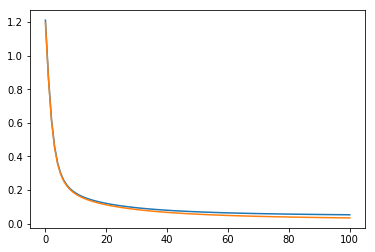

CPU times: user 3.3 s, sys: 144 ms, total: 3.44 s
Wall time: 3.27 s


In [88]:
%%time
my_NN.train(X_class,Y_class,learning_rate=10e-6,regularization=0,num_rounds=10001,print_every=1000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# 2D, regression data

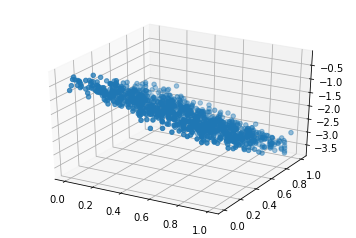

In [89]:
num_points=1000
noise_level=0.2
X_reg=np.random.uniform(0,1,(num_points,2))
plane=np.random.randn(3)
Y_reg=np.append(X_reg,np.ones((X_reg.shape[0],1)),1).dot(plane)+noise_level*np.random.randn(num_points)
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X_reg[:,0],X_reg[:,1],Y_reg)

In [93]:
my_NN=NN_01(net_structure=[3],
            f_encode_Y=lambda v: v.reshape((-1,1)),
            f_decode_Y=lambda v: v,
            f_transfer=sigmoid,
            f_output=lambda v: v,
            f_cost=rmse,
            f_accuracy=rmse)

    0  0.75021 0.73196  0.84396 0.82946     0.01    0.01    63.75
 1000  0.72683 0.69943  0.70167 0.68057     0.33    0.33     2.98
 2000  0.73663 0.70828  0.60323 0.58234     0.31    0.64     2.56
 3000  0.76145 0.73223  0.50705 0.48775     0.31    0.95     2.22
 4000  0.80013 0.76955  0.41256 0.39604     0.31    1.27     1.90
 5000  0.84672 0.81418  0.33034 0.31688     0.31    1.57     1.57
 6000  0.89203 0.85734  0.27065 0.25952     0.31    1.88     1.25
 7000  0.92917 0.89265  0.23528 0.22534     0.31    2.19     0.94
 8000  0.95610 0.91825  0.21779 0.20823     0.31    2.50     0.63
 9000  0.97409 0.93538  0.21010 0.20058     0.31    2.81     0.31
10000  0.98550 0.94628  0.20682 0.19726     0.31    3.11     0.00


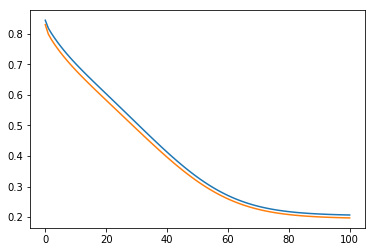

CPU times: user 3.17 s, sys: 252 ms, total: 3.42 s
Wall time: 3.26 s


In [94]:
%%time
my_NN.train(X_reg,Y_reg,learning_rate=10e-6,regularization=0,num_rounds=10001,print_every=1000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

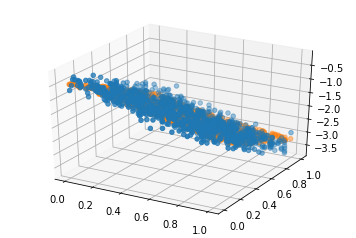

In [95]:
P=my_NN.predict(X_reg)
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X_reg[:,0],X_reg[:,1],Y_reg)
ax.scatter(X_reg[:,0],X_reg[:,1],P[-1])

## XOR gate

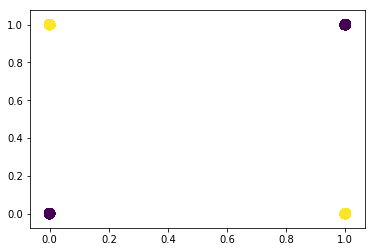

In [96]:
X_lst=[[0,0],[0,1],[1,0],[1,1]]*1000
Y_lst=[ 0,    1,    1,    0]   *1000
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

In [97]:
my_NN=NN_01(net_structure=[4],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.25125 0.24500  0.35008 0.35140     0.00    0.00    12.19
 1000  1.00000 1.00000  0.16008 0.15980     1.51    1.52     6.06
 2000  1.00000 1.00000  0.15672 0.15671     1.50    3.01     4.52
 3000  1.00000 1.00000  0.15664 0.15664     1.49    4.51     3.01
 4000  1.00000 1.00000  0.15663 0.15663     1.48    5.99     1.50
 5000  1.00000 1.00000  0.15663 0.15663     1.48    7.47     0.00


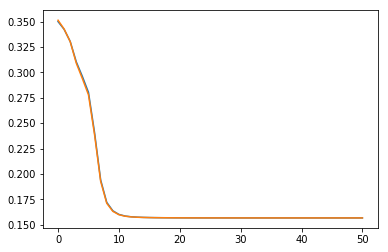

CPU times: user 7.68 s, sys: 172 ms, total: 7.85 s
Wall time: 7.64 s


In [98]:
%%time
my_NN.train(X_class,Y_class,learning_rate=0.0001,regularization=0,num_rounds=5001,print_every=1000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Donuts - balanced classes

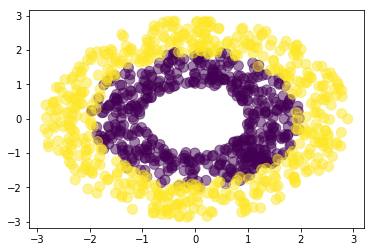

In [99]:
num_donuts=2
num_chunks=1
num_per_chunk=500
overlap=0.1
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    d_lims=sorted(list(np.random.uniform(size=num_chunks)))
    d_lims.append(d_lims[0]+1)
    for chunk in range(num_chunks):
        r=np.random.uniform(size=num_per_chunk)+(1-overlap)*donut+1
        d=2*math.pi*np.random.uniform(d_lims[chunk]  -overlap/(4*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      d_lims[chunk+1]+overlap/(4*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      size=num_per_chunk)
        X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_per_chunk)])
        Y_lst.extend([donut*num_chunks+chunk]*num_per_chunk)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

In [100]:
my_NN=NN_01(net_structure=[8,8],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.51000 0.46000  0.37081 0.38642     0.00    0.00   138.76
 5000  0.69250 0.60000  0.33774 0.34008     5.07    5.07    45.61
10000  0.77125 0.71000  0.32226 0.32652     5.08   10.15    40.59
15000  0.85000 0.82500  0.28713 0.29287     5.05   15.20    35.46
20000  0.92875 0.90500  0.22906 0.23476     5.04   20.24    30.36
25000  0.93750 0.94000  0.19105 0.19602     5.05   25.29    25.30
30000  0.94875 0.95000  0.18204 0.18281     5.07   30.36    20.24
35000  0.95125 0.95000  0.17955 0.18101     5.08   35.44    15.19
40000  0.95625 0.95000  0.17761 0.18101     5.05   40.48    10.12
45000  0.95750 0.95500  0.17595 0.17964     5.04   45.52     5.06
50000  0.96375 0.95500  0.17516 0.17953     5.03   50.55     0.00


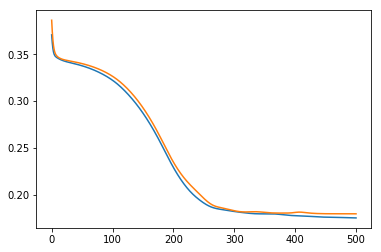

CPU times: user 50.8 s, sys: 156 ms, total: 50.9 s
Wall time: 50.8 s


In [101]:
%%time
my_NN.train(X_class,Y_class,learning_rate=0.00001,regularization=0.15,num_rounds=50001,print_every=5000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Donuts - imbalanced classes

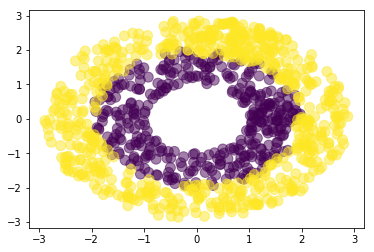

In [102]:
num_donuts=2
num_chunks=1
avg_num_per_chunk=500
overlap=0.1
tot_num=num_donuts*num_chunks*avg_num_per_chunk
min_r=1
max_r=num_donuts+1
tot_area=math.pi*(max_r**2-min_r**2)
density=1.0*tot_num/tot_area
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    min_donut_r=donut+1
    max_donut_r=donut+2
    donut_area=math.pi*(max_donut_r**2-min_donut_r**2)
    d_lims=sorted(list(np.random.uniform(size=num_chunks)))
    d_lims.append(d_lims[0]+1)
    for chunk in range(num_chunks):
        chunk_area=donut_area*(d_lims[chunk+1]-d_lims[chunk])
        num_in_chunk=int(density*chunk_area)
        r=np.random.uniform(size=num_in_chunk)+(1-overlap)*donut+1
        d=2*math.pi*np.random.uniform(d_lims[chunk]  -overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      d_lims[chunk+1]+overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      size=num_in_chunk)
        X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_in_chunk)])
        Y_lst.extend([donut*num_chunks+chunk]*num_in_chunk)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

In [103]:
my_NN=NN_01(net_structure=[8,8],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.39000 0.31500  0.36758 0.37477     0.00    0.00   147.66
 5000  0.61000 0.68500  0.33144 0.31459     5.08    5.08    45.71
10000  0.61000 0.68500  0.32556 0.31047     5.05   10.13    40.53
15000  0.61000 0.68500  0.30789 0.29623     5.05   15.18    35.42
20000  0.73875 0.78000  0.28197 0.27230     5.05   20.23    30.35
25000  0.89875 0.91000  0.23136 0.22536     5.14   25.37    25.37
30000  0.92250 0.94500  0.20033 0.19362     5.04   30.41    20.28
35000  0.94375 0.97000  0.18668 0.17429     5.04   35.45    15.20
40000  0.95125 0.97000  0.18087 0.17144     5.03   40.49    10.12
45000  0.95625 0.97500  0.17926 0.17134     5.10   45.59     5.07
50000  0.95750 0.97000  0.17745 0.17183     5.02   50.61     0.00


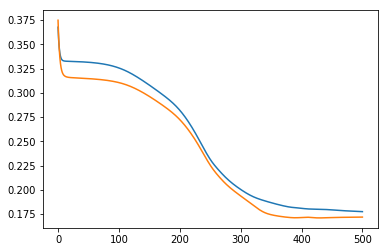

CPU times: user 50.8 s, sys: 176 ms, total: 51 s
Wall time: 50.8 s


In [104]:
%%time
my_NN.train(X_class,Y_class,learning_rate=0.00001,regularization=0.15,num_rounds=50001,print_every=5000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Donut chunks - balanced classes

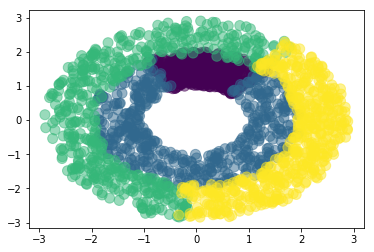

In [105]:
num_donuts=2
num_chunks=2
num_per_chunk=500
overlap=0.1
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    d_lims=sorted(list(np.random.uniform(size=num_chunks)))
    d_lims.append(d_lims[0]+1)
    for chunk in range(num_chunks):
        r=np.random.uniform(size=num_per_chunk)+(1-overlap)*donut+1
        d=2*math.pi*np.random.uniform(d_lims[chunk]  -overlap/(4*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      d_lims[chunk+1]+overlap/(4*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      size=num_per_chunk)
        X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_per_chunk)])
        Y_lst.extend([donut*num_chunks+chunk]*num_per_chunk)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

In [106]:
my_NN=NN_01(net_structure=[8,8],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.07312 0.07500  0.36123 0.35842     0.00    0.00   176.31
 5000  0.58437 0.60500  0.27998 0.28042    10.36   10.37    93.28
10000  0.65938 0.68000  0.26718 0.26588    10.33   20.69    82.76
15000  0.66063 0.69250  0.27067 0.26822    10.32   31.02    72.37
20000  0.66250 0.69000  0.26820 0.26611    10.24   41.26    61.89
25000  0.66375 0.69500  0.26519 0.26326    11.03   52.29    52.29
30000  0.69688 0.72500  0.25675 0.25462    12.63   64.92    43.28
35000  0.71875 0.74250  0.25278 0.25090    11.34   76.26    32.69
40000  0.73875 0.76000  0.25264 0.25036    12.18   88.44    22.12
45000  0.69437 0.73250  0.25252 0.25063    11.40   99.84    11.10
50000  0.69500 0.73500  0.25294 0.25030    10.29  110.13     0.00


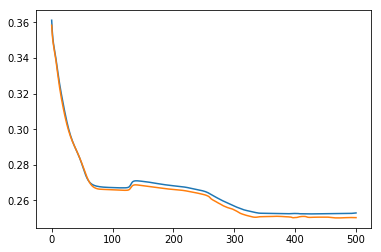

CPU times: user 1min 50s, sys: 188 ms, total: 1min 50s
Wall time: 1min 50s


In [107]:
%%time
my_NN.train(X_class,Y_class,learning_rate=0.00001,regularization=0.15,num_rounds=50001,print_every=5000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Donut chunks - imbalanced classes

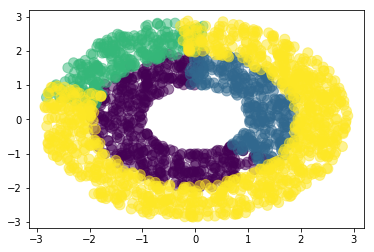

In [112]:
num_donuts=2
num_chunks=2
avg_num_per_chunk=500
overlap=0.1
tot_num=num_donuts*num_chunks*avg_num_per_chunk
min_r=1
max_r=num_donuts+1
tot_area=math.pi*(max_r**2-min_r**2)
density=1.0*tot_num/tot_area
X_lst=[]
Y_lst=[]
for donut in range(num_donuts):
    min_donut_r=donut+1
    max_donut_r=donut+2
    donut_area=math.pi*(max_donut_r**2-min_donut_r**2)
    d_lims=sorted(list(np.random.uniform(size=num_chunks)))
    d_lims.append(d_lims[0]+1)
    for chunk in range(num_chunks):
        chunk_area=donut_area*(d_lims[chunk+1]-d_lims[chunk])
        num_in_chunk=int(density*chunk_area)
        r=np.random.uniform(size=num_in_chunk)+(1-overlap)*donut+1
        d=2*math.pi*np.random.uniform(d_lims[chunk]  -overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      d_lims[chunk+1]+overlap/(2*num_chunks)*(d_lims[chunk+1]-d_lims[chunk]),
                                      size=num_in_chunk)
        X_lst.extend([[r[n]*math.cos(d[n]),r[n]*math.sin(d[n])] for n in range(num_in_chunk)])
        Y_lst.extend([donut*num_chunks+chunk]*num_in_chunk)
X_class=np.array(X_lst)
Y_class=np.array(Y_lst)
plt.scatter(X_class[:,0],X_class[:,1],c=Y_class,s=100,alpha=0.5)
plt.show()

In [113]:
my_NN=NN_01(net_structure=[8,8],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.13571 0.12531  0.34675 0.34997     0.00    0.00   176.41
 5000  0.48218 0.52882  0.30259 0.29772    10.49   10.50    94.45
10000  0.48218 0.52882  0.30197 0.29628    10.41   20.90    83.61
15000  0.48218 0.52882  0.30005 0.29353    10.36   31.27    72.96
20000  0.48218 0.52882  0.28794 0.27983    10.38   41.65    62.48
25000  0.48218 0.52882  0.29036 0.28268    10.37   52.02    52.02
30000  0.62164 0.64411  0.29252 0.28469    12.33   64.35    42.91
35000  0.66792 0.67920  0.28886 0.28515    13.04   77.40    33.17
40000  0.67855 0.68672  0.27558 0.27319    11.39   88.78    22.20
45000  0.67855 0.68421  0.27416 0.27161    12.03  100.81    11.21
50000  0.68105 0.68672  0.27390 0.27117    11.29  112.10     0.00


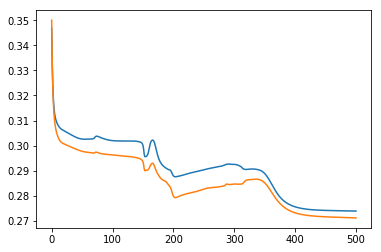

CPU times: user 1min 52s, sys: 344 ms, total: 1min 52s
Wall time: 1min 52s


In [116]:
%%time
my_NN.train(X_class,Y_class,learning_rate=0.00001,regularization=0.15,num_rounds=50001,print_every=5000,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)